# Spanish Translation A/B Test Challenge

### Jon Zeller
### 12-21-2016

## Problem Statement
You are asked to:  
--Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better  
--Explain why that might be happening. Are the localized translations really worse?  
--If you identified what was wrong, design an algorithm that would return FALSE if thesame problem is happening in the future and TRUE if everything is good and the results can be trusted.

## Data Description

#### Test Table
--user_id : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started.  
--date : when they came to the site for the first time since the test started  
--source : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc.  
--device : device used by the user. It can be mobile or web  
--browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish)  
--ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA  
--browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera  
--conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert.  
--test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.  

#### User Table
--user_id : the id of the user. It can be joined to user id in the other table  
--sex : user sex: Male or Female  
--age : user age (self-reported)  
--country : user country based on ip address  

### Part 0 - Setup, Import, and Exploration

Before performing any analysis, we will import the data and perform a little bit of exploration to ensure everything looks normal enough to proceed. This will mostly involve checking for missing values and examining the distributions of variables to perform a 'sanity check.'

In [2]:
# setup and import
## basics
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

## date manipulation
from dateutil.parser import parse

## plotting
import matplotlib.pyplot as plt
%pylab inline

## formulas
import patsy

Populating the interactive namespace from numpy and matplotlib


In [3]:
# create dataframes of provided data, setting index to user_id
test = pd.read_csv('test_table.csv',index_col='user_id')
user = pd.read_csv('user_table.csv',index_col='user_id')

In [4]:
# check for duplicate indices
len(test.index.values)/(len(Series(test.index.values).unique())*1.0)
## length of the index divided by the length of the de-duplicated index is 1, no duplicates! this means one entry per user

1.0

In [5]:
len(user.index.values)/(len(Series(user.index.values).unique())*1.0)
## length of the index divided by the length of the de-duplicated index is 1, no duplicates! this means one entry per user

1.0

In [6]:
# let's look at the first few rows
test.head()

,date,source,device,browser_language,ads_channel,browser,conversion,test
user_id,,,,,,,,
315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [7]:
user.head()

,sex,age,country
user_id,,,
765821,M,20,Mexico
343561,F,27,Nicaragua
118744,M,23,Colombia
987753,F,27,Venezuela
554597,F,20,Spain


In [8]:
# let's look at the data types to ensure everything is what it should be
test.dtypes

## we want conversion and test to be integers - looks good! 
## everything else is an object/string - let's convert date into a date so we can use it later if needed

date                object
source              object
device              object
browser_language    object
ads_channel         object
browser             object
conversion           int64
test                 int64
dtype: object

In [9]:
test['date'] = test['date'].map(lambda x: parse(x))

In [10]:
user.dtypes

## everything looks ok here!

sex        object
age         int64
country    object
dtype: object

In [11]:
# Let's see if we have any missing values - let's define a function to give us the "fill percentage" of each column in a df:

def fillprc(dff):
    fillprc = [] # initialize empty list to be returned later
    dfcols = list(dff.columns.values) # get list of all column names
    for i in range(0,len(dfcols)): # loop through each column and get percentage filled, defined as ratio of lengths
        colname = dfcols[i]
        collfillprc = float(dff[dfcols[i]].value_counts().sum())/dff[dfcols[i]].value_counts(dropna=False).sum()
    
        fillprc.append((colname,collfillprc)) # add tuple of colname and percentage filled to list
     
    missinglist = [f for f in fillprc if f[1] != 1] # Filter fillprc list for less than 100%

    return missinglist # spit out the list

In [12]:
fillprc(test)
## everything is 100% filled except ads channel. From the data description, we know a missing value here means the user did
## not come via an ad. let's fill this in so we can use for later analysis

[('ads_channel', 0.40121017998283776)]

In [13]:
test['ads_channel'] = test['ads_channel'].fillna(value='None')

In [14]:
test['ads_channel'].value_counts()
## looks good!

None        271444
Facebook     68425
Google       68180
Yahoo        27435
Bing         13689
Other         4148
Name: ads_channel, dtype: int64

In [15]:
fillprc(user)
## no missing values here - excellent!

[]

In [16]:
# Let's sanity check a few different columns in each dataframe

test['browser_language'].value_counts()
## makes sense - mostly in Spanish, some English, and a few others

ES       377547
EN        63137
Other     12637
Name: browser_language, dtype: int64

In [17]:
test['browser'].value_counts()
## seems reasonable - our users appear to be big fans of Google!

Android_App    155135
Chrome         101929
IE              61715
Iphone_App      46621
Safari          41065
FireFox         40766
Opera            6090
Name: browser, dtype: int64

In [18]:
test['date'].value_counts()
## looks like the data was collected over a period of five consecutive days - this is good - it means there were probably no
## fundamental changes in the user base or product or anything else that could potentially skew the analysis

2015-12-04    141163
2015-12-03     99493
2015-11-30     71025
2015-12-01     70991
2015-12-02     70649
Name: date, dtype: int64

In [19]:
test['test'].value_counts()
## Users were split into test and control groups fairly equally, at least from a raw numerical perspective
## Later, we will examine how the pool of users in each group "looks" to ensure there was no bias in the group creation

0    237338
1    215983
Name: test, dtype: int64

In [20]:
user['age'].describe()
## average age of 27, 75% of users are 31 or under - so we have a fairly young population, which makes sense for online business

count    452867.000000
mean         27.130740
std           6.776678
min          18.000000
25%          22.000000
50%          26.000000
75%          31.000000
max          70.000000
Name: age, dtype: float64

In [21]:
user['sex'].value_counts()
## Significantly more males than females. Depending on the product or other demographic/cultural considerations, this could
## be reasonable. We will enure to control for gender in later analysis.

M    264485
F    188382
Name: sex, dtype: int64

In [22]:
user['country'].value_counts()
## We have users from all across the Spanish-speaking world. Other than Spain, all of these countries are in Central and South
## America. This could be significant later

Mexico         128484
Colombia        54060
Spain           51782
Argentina       46733
Peru            33666
Venezuela       32054
Chile           19737
Ecuador         15895
Guatemala       15125
Bolivia         11124
Honduras         8568
El Salvador      8175
Paraguay         7347
Nicaragua        6723
Costa Rica       5309
Uruguay          4134
Panama           3951
Name: country, dtype: int64

#### Dependent Variable
Let's examine our dependent variable *conversion* just a bit

In [23]:
test['conversion'].value_counts()
## overall we have around 453k observations and 22k conversions for a conversion rate of slightly below 5%

0    430846
1     22475
Name: conversion, dtype: int64

In [24]:
# how does conversion percentage vary across language?
conv_count_lang = pd.crosstab(test['browser_language'],test['conversion'])
conv_count_lang['convprc'] = conv_count_lang[1]/(1.0*conv_count_lang[0]+conv_count_lang[1])
conv_count_lang
## conversions in each language are all slightly below 5% - nothing out of the ordinary

conversion,0,1,convprc
browser_language,,,
EN,60083,3054,0.048371
ES,358754,18793,0.049777
Other,12009,628,0.049695


In [25]:
# how does conversion percentage vary across day?
conv_count_date = pd.crosstab(test['date'],test['conversion'])
conv_count_date['convprc'] = conv_count_date[1]/(1.0*conv_count_date[0]+conv_count_date[1])
conv_count_date
## conversions each day are similar - doesn't appear to be anything odd here either

conversion,0,1,convprc
date,,,
2015-11-30,67407,3618,0.050940
2015-12-01,67599,3392,0.047781
2015-12-02,67111,3538,0.050079
2015-12-03,94491,5002,0.050275
2015-12-04,134238,6925,0.049057


At this point, we have two relatively clean dataframes and we have a general feel for how the data looks, so we can feel comfortable addressing the challenges.

### Part 1: Confirm the test is negative

In this section, we are attempting to determine if there is actually a negative relationship between local translation and conversion rate. Eventually, we will want to isolate the relationship between this one variable - *test* - and our dependent variable (*conversion*), but for now let's begin with some simple summary tables on un-modified data. Hopefully, we can reproduce the unexpected result and go deeper from there.

In [26]:
# How does conversion percentage vary across the test and control groups? 
conv_count_test = pd.crosstab(test['test'],test['conversion'])
conv_count_test['convprc'] = conv_count_test[1]/(1.0*conv_count_test[0]+conv_count_test[1])
conv_count_test

conversion,0,1,convprc
test,,,
0,224242,13096,0.055179
1,206604,9379,0.043425


In [27]:
# Let's test for independence of these two variables using a chi-squared test

from scipy.stats import chi2_contingency
chi2_contingency(pd.crosstab(test['test'],test['conversion']), correction=False)[1] # the 2nd item in this object is the p-value
## We see the p-value for independence of test and conversion is extremely small, indicating that we can reject the null
## hypothesis of independence among these two variables. 

4.4320956939216634e-74

Looking at the table above, we can see that the conversion percentage for users who saw the local translations - where *test* = 1 - have an overall conversion percentage of around 4.3%, whereas this number for users who saw the standard translations is about 5.5%. These results likely represent the phenomenon observed by the country managers that non-localized translations are actually performing worse. Looking at the results of the chi-squared test that tests for independence between these two variables, we can conclude the difference is statistically significant based on an extremely small p-value, and reject the null hypothesis of independence. 

However, without controlling for the effects other variables like ads, demographics, etc., we cannot conclude that the test is actually related to the decrease in performance. Additionally, this includes users from Spain. From both a business and data perspective, we are not really concerned with these users. This is because the problem statement is around poor performance of local translations in countries other than Spain. So, to understand if these translations are having a negative effect on conversion, we need to examine data from non-Spanish countries.

In [28]:
# To identify non-Spanish countries, we need to bring together both dataframes

test_demo = test.merge(user, how = 'left', left_index=True, right_index=True)
## use a left join to ensure we do not lose any test observations and only add demographic data where we have it

In [29]:
test_demo.head()
## this looks correct!

,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
user_id,,,,,,,,,,,
315281,2015-12-03,Direct,Web,ES,None,IE,1,0,M,32.0,Spain
497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [30]:
# let's examine if we have users in the test dataset that are missing demographic information

fillprc(test_demo)
## we only have a few observations - less than .002 - that are missing demographic information. Since we cannot determine country
## for these users, let's drop them

[('sex', 0.9989985021651324),
 ('age', 0.9989985021651324),
 ('country', 0.9989985021651324)]

In [31]:
test_demo_c = test_demo.dropna()

In [32]:
shape(test_demo_c)[0]/(shape(test_demo)[0]*1.0)
## we still have 99.89% of the data intact!

0.9989985021651324

In [33]:
test_demo_c['country'].value_counts()

Mexico         128484
Colombia        54060
Spain           51782
Argentina       46733
Peru            33666
Venezuela       32054
Chile           19737
Ecuador         15895
Guatemala       15125
Bolivia         11124
Honduras         8568
El Salvador      8175
Paraguay         7347
Nicaragua        6723
Costa Rica       5309
Uruguay          4134
Panama           3951
Name: country, dtype: int64

In [34]:
# let's create a dataframe of non-spanish users so we can focus on users relevant to our business problem
test_nosp = test_demo_c[test_demo_c['country'] != 'Spain']

In [35]:
test_nosp['country'].value_counts()
## it worked

Mexico         128484
Colombia        54060
Argentina       46733
Peru            33666
Venezuela       32054
Chile           19737
Ecuador         15895
Guatemala       15125
Bolivia         11124
Honduras         8568
El Salvador      8175
Paraguay         7347
Nicaragua        6723
Costa Rica       5309
Uruguay          4134
Panama           3951
Name: country, dtype: int64

In [36]:
test_nosp['test'].value_counts()
## we can see about 54% of users outside of spain are in the test group, meaning they were shown local translations

1    215774
0    185311
Name: test, dtype: int64

In [37]:
# How does conversion percentage vary across the test and control groups for countries other than Spain?
conv_count_test_nosp = pd.crosstab(test_nosp['test'],test_nosp['conversion'])
conv_count_test_nosp['convprc'] = conv_count_test_nosp[1]/(1.0*conv_count_test_nosp[0]+conv_count_test_nosp[1])
conv_count_test_nosp

conversion,0,1,convprc
test,,,
0,176362,8949,0.048292
1,206407,9367,0.043411


In [38]:
# Let's test for independence of these two variables using a chi-squared test
chi2_contingency(pd.crosstab(test_nosp['test'],test_nosp['conversion']), correction=False)[1] # the 2nd item in this object
# is the p-value

## We see the p-value for independence of test and conversion is extremely small, indicating that we can reject the null
## hypothesis of independence among these two variables. 

1.5619993923595226e-13

Once we isolate non-Spanish countries, we see the conversion percent is still lower for users who see the local translations. The conversion percentage for test users is the same - 4.3% - because there were no test users in Spain. Looking at the control group users, the conversion percentage is down to around 4.8%. This is lower than the group that includes Spanish users, but based on the chi-squared test, is still significantly different than the conversion rate for users in the test group.

At this point, we can conclude that the test results are actually negative - users in the test group have a lower conversion rate. However, we **cannot conclude** that the test is the cause of the discrepancy. We have not accounted for any sampling errors or other factors that may affect the results. This will be the enxt step of our analysis.

### Part 2 - Explain why that might be happening. Are the localized translations really worse?

In this section, we will attempt to discover why the localized translations are correlated with a lower conversion rate. Now that we have established that the group of non-Spanish users who were shown local translations convert at a lower rate, we must examine both pools of users to identify any potential differences other than the test itself 

In [39]:
# Let's first look at distribution of country in the test and control groups
pd.crosstab(test_nosp['country'],test_nosp['test'])

test,0,1
country,,
Argentina,9356,37377
Bolivia,5550,5574
Chile,9853,9884
Colombia,27088,26972
Costa Rica,2660,2649
Ecuador,8036,7859
El Salvador,4108,4067
Guatemala,7622,7503
Honduras,4361,4207


In [40]:
# create dataframes of fractions of each country in both test and control groups
s1 = DataFrame(test_nosp['country'][test_nosp['test'] == 1].value_counts()/test_nosp['country'][test_nosp['test'] == 1].value_counts().sum())
s2 = DataFrame(test_nosp['country'][test_nosp['test'] == 0].value_counts()/test_nosp['country'][test_nosp['test'] == 0].value_counts().sum())


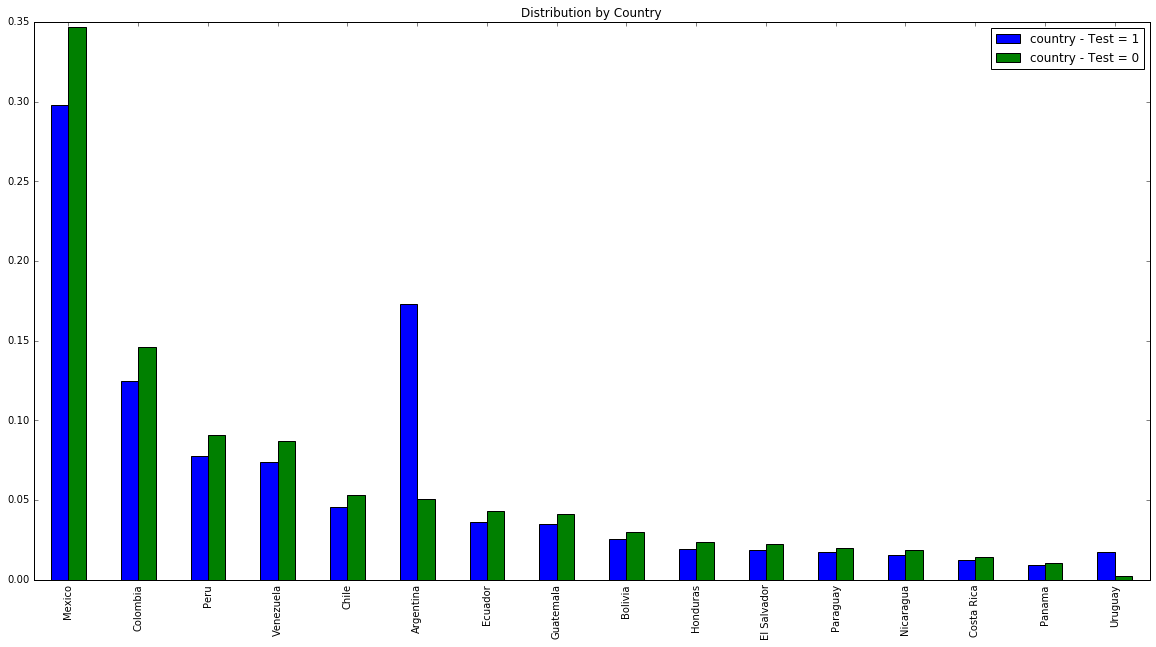

In [41]:
# merge two dataframes of contry proportions into one DF and plot
s3 = s1.merge(s2, how='inner',left_index=True,right_index=True,suffixes=(' - Test = 1',' - Test = 0'))
s3.plot(kind='bar',figsize=(20,10),title='Distribution by Country')

As we can see above, the test and control groups have a fairly similar distribution of countries other than Spain, except that the test group has a disproportionately large number of users from Argentina. This has the potential to affect our results - let's dig deeper into response rate in Argentina. If it's significantly lower than other countries, then having a lot more Argentinian users in the test group could be the cause of the difference. 

In [42]:
# Let's get response rate for each country, for both test and control groups

resp_ct_t0 = test_nosp[['country','conversion']][test_nosp['test'] == 0]
t0_group = resp_ct_t0.groupby('country').mean()

resp_ct_t1 = test_nosp[['country','conversion']][test_nosp['test'] == 1]
t1_group = resp_ct_t1.groupby('country').mean()

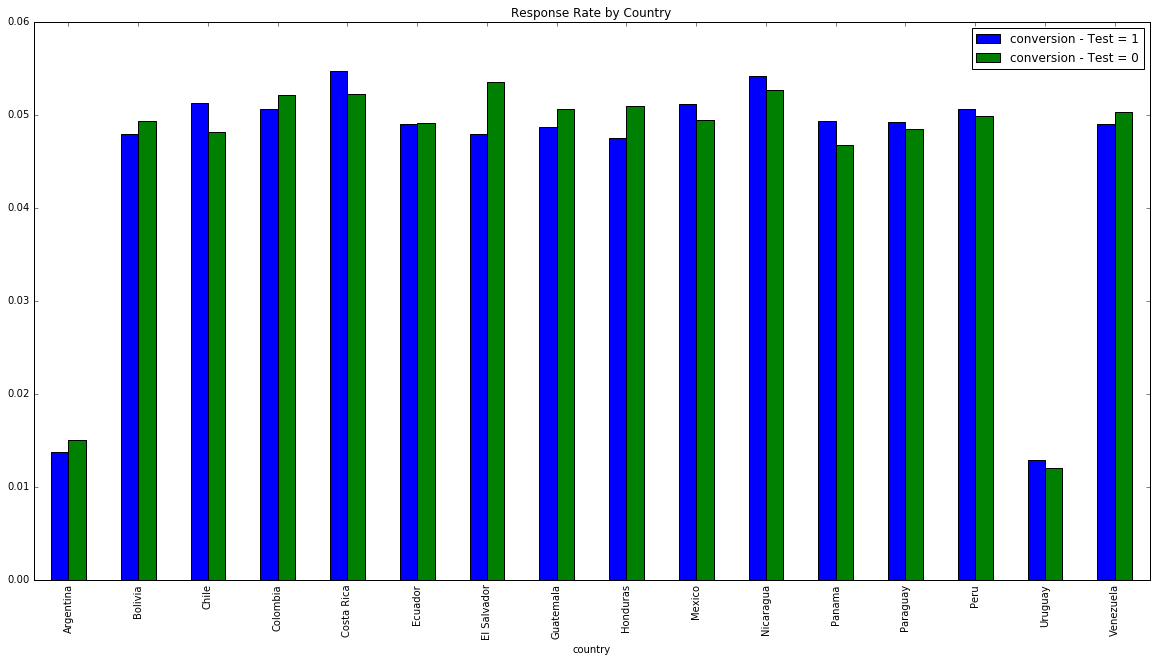

In [43]:
# merge two dataframes of contry proportions into one DF and plot
resp_groups = t1_group.merge(t0_group, how='inner',left_index=True,right_index=True,suffixes=(' - Test = 1',' - Test = 0'))
resp_groups.plot(kind='bar',figsize=(20,10),title='Response Rate by Country')

Looking at the plot above, we can conclude a couple of things. First, response rate by country does not really vary across the test and control groups, which implies that within a given country, the test treatment does not appear to affect our response variable. This is in direct contradiction with the initial conclusion that the response rates are lower for the test group.

However, we also notice some outlier countries in response rate. Uruguay and Argentina both respond at around 1%, whereas all other countries are close to 5%. So, combined with the information from the previous graph - that Argentina is over-represented in the test group - we see there may be a possible cause for our curious initial results. 

Before we attempt to confirm this hypothesis statistically, we will perform similar analysis for other independent variables, just to make sure we don't miss anything else. We will do so by comparing the differences in proportions for the test and control groups, and append any value that exceeds a given threshold to a list for later examination.

In [102]:
# create list of all independent variables
varlist = list(test_nosp.columns - ['conversion','test'])

# initialize lists to store results
difflist = []
errorlist = []

# loop through all independent variables
for i in varlist:
    # calculate fraction of each category for each independent variable
    s1_i = DataFrame(test_nosp[i][test_nosp['test'] == 1].value_counts()/test_nosp[i][test_nosp['test'] == 1].value_counts().sum())
    s2_i = DataFrame(test_nosp[i][test_nosp['test'] == 0].value_counts()/test_nosp[i][test_nosp['test'] == 0].value_counts().sum())
    s3_i = s1_i.merge(s2_i, how='inner',left_index=True,right_index=True,suffixes=(' - Test = 1',' - Test = 0'))
    
    # check difference in each category for each variable
    for j in range(len(s3_i)):
        # try to find the abs value in the difference, if it exceeds 1%, add to the list of results
        try:
            if np.abs(s3_i.ix[j][0] - s3_i.ix[j][1]) > .01:
                difflist.append((i,s3_i.ix[j].name))
        # due to some key error issues, store excepted values for later checking by hand
        except KeyError:
            errorlist.append((i,j))
            
difflist, errorlist

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


([('country', 'Mexico'),
  ('country', 'Colombia'),
  ('country', 'Peru'),
  ('country', 'Venezuela'),
  ('country', 'Argentina'),
  ('country', 'Uruguay')],
 [('age', 0),
  ('age', 1),
  ('age', 2),
  ('age', 3),
  ('age', 4),
  ('age', 5),
  ('age', 6),
  ('age', 7),
  ('age', 8),
  ('age', 9),
  ('age', 10),
  ('age', 11),
  ('age', 12),
  ('age', 13),
  ('age', 14),
  ('age', 15),
  ('age', 16),
  ('age', 17)])

Looking at the lists above, we see that only the distribution of countries varies significantly across the test and control groups, so other errors due to biased sampling of other variables will likely be minimized.

The error list shows that we got key errors in the *age* variable due to numerical values as keys, but luckily nowhere else. Let's check this by hand below to make sure the distribution of ages looks acceptable.

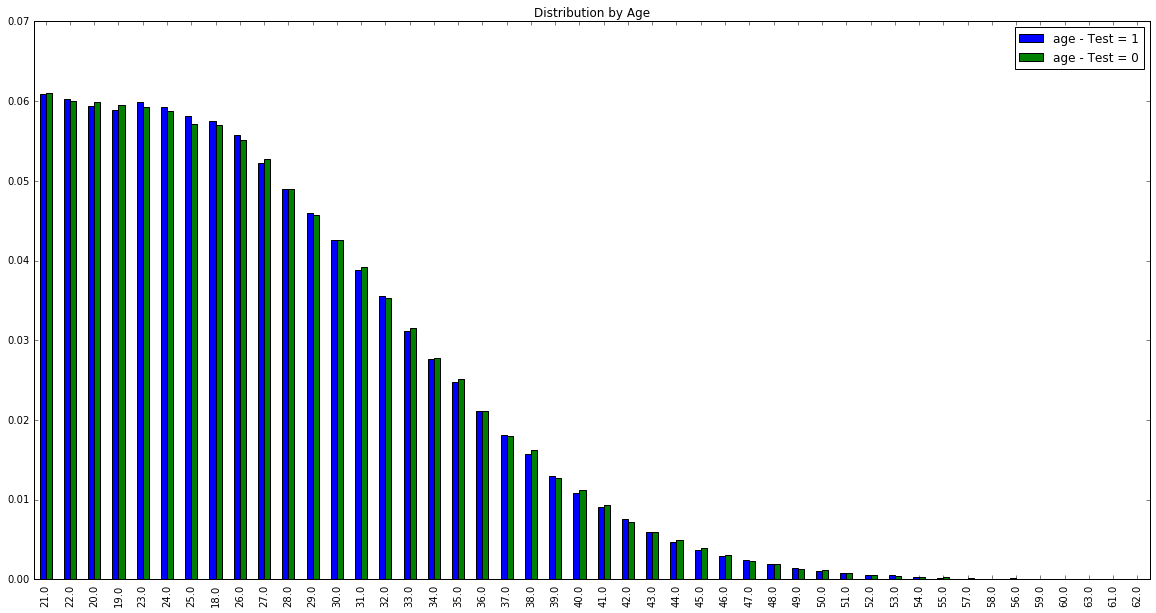

In [103]:
# create dataframes of fractions of each age in both test and control groups
s1 = DataFrame(test_nosp['age'][test_nosp['test'] == 1].value_counts()/test_nosp['age'][test_nosp['test'] == 1].value_counts().sum())
s2 = DataFrame(test_nosp['age'][test_nosp['test'] == 0].value_counts()/test_nosp['age'][test_nosp['test'] == 0].value_counts().sum())


# merge two dataframes of contry proportions into one DF and plot
s3 = s1.merge(s2, how='inner',left_index=True,right_index=True,suffixes=(' - Test = 1',' - Test = 0'))
s3.plot(kind='bar',figsize=(20,10),title='Distribution by Age')

The distribution of ages is roughly the same in both the test and control groups, so again we can conclude that there is no sampling bias in this variable. 

#### Statistical Analysis

The "quick and dirty" analysis above indicates that excepting for country, all other variables are distributed roughly equally across the test and control group. We have also noticed that the test group has a disprportionately high number of users from Argentina, a country with much lower response rates than average, which is likely causing the high-level result that users in the test group convert at a lower rate. 

To get closer to uncovering the *true* relationship between the localized translations and conversion rate, we can run a logistic regression predicting the probability of conversion and include *test* as well as our demographic and other user-based data as predictor variables.

In [81]:
test_nosp.head()

,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
user_id,,,,,,,,,,,
497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
540675,2015-12-03,Direct,Mobile,ES,None,Android_App,0,1,F,22.0,Venezuela
863394,2015-12-04,SEO,Mobile,Other,None,Android_App,0,0,M,35.0,Mexico


In [110]:
# import modeling packages
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression

In [107]:
### Let's run model with everything
# create list of columns and specify patsy formula
model2_c = " + ".join(test_nosp.columns - ['conversion','date'])
model2 = 'conversion ~' + model2_c

# create x and y matrices
y,x = patsy.dmatrices(model2, test_nosp, return_type='dataframe')

# specify and fit model 
fit2 = LogisticRegression()
fit2.fit(x,y)

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  app.launch_new_instance()


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [120]:
# get p-values
feat2 = f_regression(x, y)

# create DF to store coefficients and p-values
r2 = DataFrame(data=fit2.coef_[0],index=x.columns.values,columns=['coefficient'])
r2['pval'] = feat2[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,pval,sig
Intercept,-2.141095,NaN,False
ads_channel[T.Facebook],0.067987,8.940296e-02,False
ads_channel[T.Google],0.035748,8.870236e-01,False
ads_channel[T.None],0.023380,5.381704e-01,False
ads_channel[T.Other],-0.110494,7.297012e-02,False
ads_channel[T.Yahoo],0.049509,7.018742e-01,False
browser[T.Chrome],-0.007175,9.871562e-01,False
browser[T.FireFox],-0.007489,9.094803e-01,False
browser[T.IE],-0.025114,3.979362e-01,False
browser[T.Iphone_App],0.013884,2.707904e-01,False


Looking at all of the results from the logistic regression, we see that most variables are not significant at a 1% level, with most significant variables being country indicators. In the next cell, we will look just at significant variables and attempt to draw some conclusions.

In [118]:
# Let's just examine variables significant at a 1% level
r2[r2['sig'] == True]

,coefficient,pval,sig
country[T.Chile],1.272445,5.327854e-03,True
country[T.Colombia],1.307445,1.167774e-11,True
country[T.Costa Rica],1.347201,5.951718e-03,True
country[T.Mexico],1.287182,2.100723e-22,True
country[T.Nicaragua],1.347854,2.191947e-03,True
country[T.Peru],1.285208,2.474133e-05,True
country[T.Uruguay],-0.128098,2.718072e-24,True
country[T.Venezuela],1.273161,3.483266e-04,True
test,0.001502,1.559329e-13,True


The above variables are all significant at a 1% level, so we can reject the null hypothesis that they have no effect on the probability of conversion. Excepting *test* and the indicator variable for a user in Uruguay, the rest of the significant variables are country indicators with a value of approximately 1.3. This means that any of these values being equal to true - if the user is in any of these countries - means the log-odds of the probability of conversion increases by 1.3. Raising *e* to this value gives us approximately 3.66, so that a user is 3.66 times more likely to convert if they are in one of these countries compared to the base case of Argentina. We saw earlier that Argentina has a conversion rate far below most other countries, so the significance of these variables is essentially applying a correction back to the non-Argentina level. *e* raised to Uruguay's coefficient of -.12 yields approximately .9, so that Uruguayan users are 90% as likely to convert as an Argentinian user, all else being equal.

In a regression that accounts for all of the other information we have, the coefficient associated with the test treatment - local translations - is actually statistically significant with an exceedingly small p-value. However, its coefficient is so close to zero that the true effect is immaterial. *e* raised to this power is almost exactly one, so that the odds of conversion are unaffected by the test treatment. 

Based on our exploratory analysis, we can conclude that the local translations effectively have no effect on conversion rate, and the difference in overall conversion rate for the test and control groups is due to sampling bias. Users from Argentina are overrepresented in the test group, and these users have much lower conversion rates, which drags down the overall conversion rate. When we account for this imbalance, we do not see a significant effect of the test treatment, based on the results from a logistic regression.

### Part 3 - If you identified what was wrong, design an algorithm that would return FALSE if thesame problem is happening in the future and TRUE if everything is good and the results can be trusted.

We have established that the problem is sampling bias, so we must develop a test to ensure that users are distributed in the same way across both the test and control groups. We will modify the test used above to create a function that takes a dataframe of observed user data and compares how it looks across all of our independent variables in the test and control groups. 

In [144]:
def disttest(df, test, thresh, exclcols):
    ### inputs:
    # df: dataframe of observed variables
    # test: column in df that indicates test (1) and control (0) treatment groups
    # exclcols: list of columns to exclude from analysis - dependent variable, timestamp, etc. for now, exclude numerical columns
    # thresh: percentage difference threshold to include in results
    
    # create list of variables we care about    
    varlist = list(df.columns - exclcols - [test])
    
    # initialize results to return
    difflist = []
    
    # loop through each variable we care about
    for i in varlist:
        # calculate fraction of each category for each independent variable for both test and control
        test1_i = DataFrame(df[i][df[test] == 1].value_counts()/df[i][df[test] == 1].value_counts().sum())
        test0_i = DataFrame(df[i][df[test] == 0].value_counts()/df[i][df[test] == 0].value_counts().sum())
        t_i = test1_i.merge(test0_i, how='inner',left_index=True,right_index=True,suffixes=(' - Test = 1',' - Test = 0'))
        
        # loop through each category for each variable
        colcats = list(t_i.index.values)
        for j in colcats:
            # if difference in proportion exceeds threshold, add it to the results list
            if np.abs(t_i.ix[j][0] - t_i.ix[j][1]) > thresh:
                difflist.append((i,j))
    
    # if list is empty - i.e. no variables have different proportions - then return true, otherwise print warning and return list
    if difflist == []:
        return True
    else: 
        print "FALSE: One or more variables may have sampling bias, see printout of misaligned distributions below"
        return difflist
        
        

In [145]:
# let's test this with the above data - we should see the six countries we identified earlier
disttest(df=test_nosp, exclcols=['conversion','date'],test='test',thresh=.01)
## we do!

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


FALSE: One or more variables may have sampling bias, see printout of misaligned distributions below


[('country', 'Mexico'),
 ('country', 'Colombia'),
 ('country', 'Peru'),
 ('country', 'Venezuela'),
 ('country', 'Argentina'),
 ('country', 'Uruguay')]

In [143]:
# let's test the function excluding country from analysis - the function should return True
disttest(df=test_nosp, exclcols=['conversion','date','country'],test='test',thresh=.01)
## it does!!

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()


True

## Conclusion

We were able to successfully answer the three posed questions:

1. We confirmed that the overall conversion rate is indeed lower for users who saw the localized translations, so at a high level, the test is actually negative and the difference is statistically significant. We excluded Spain from analysis, since the problem concerns countries who will see local translations rather than those from Spain. 

2. We identified that the discrepancy in results is not actually due to the test itself, but rather due to an imbalance in the distribution of users in the test and control groups. Users in the test group, who saw localized translations, had a much higher proportion of Argentine users, who convert at a much lower rate than most other countries. This imbalance is what led to the perceived lower response rate for test group users. A logistic regression that included all demographic information as well as the test/control split showed that the test variable itself had very little effect on the probability of conversion, while Argentinian and Uruguayan users were much less likely to convert. 

3. To prevent future sampling bias, we developed a function that takes a dataframe of observed results and compares the proportion of each category for each variable for both the test and control groups. If the difference in these proportions across test and control exceeds a specified threshold, the variable and categroy is returned for further analysis. At the moment, this does not include code to handle numerical variables, so a necessary next step is to expand the function to check the variable type, and if it's numerical, compare the mean and standard deviation rather than the proportion in each category.

Although we can conclude for now that the local translations do not actually negatively affect results, there are some risks and more analysis is necessary. For example, it is possible that the test did not run long enough (data is only from three days) and conversion data was not accurately gathered. Or, users may be buying products or services not covered in the conversion metric. Additionally, the translations may have different effects on different users. For example, if a certain demographic is interested in the product because of its associations with Spain, then that group may be less likely to purchas upon seeing local translations. 

Next steps include re-running the test for a longer time period, re-examining what defines a "conversion," and exploring the effect of translations on different product or user groups. As well, metrics other than conversion could be studied - such as time spent on the site, types of products or pages viewed, etc.

In terms of more robust statistical analysis, additional logistic regressions or other binary classification tools could be applied to uncover additional relationships between variables. Since we are more concerned with the relationships bewteen variables rather than out-of-sample prediction, additional significance tests such as chi-squared could be used. The sampling bias test function could be amended to automatically perform tests for statistical significance instead of comparing to a pre-defined threshold, as well as improved by adding the ability to handle numerical variables as discussed above.